In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_5126/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Load experimental results from files.

from pathlib import Path
import re
import yaml
from yaml import SafeLoader

EXP_PATH = "/home/hazrael/GitRepositories/storalloc-gitlab/simulation/results"
# EXP_NAME = ["exp__18-Mar-22_09-46", "exp__18-Mar-22_11-08", "exp__18-Mar-22_15-18"]
EXP_NAME = ["exp__20-Mar-22_11-09"]

exp_data = []

infra_pattern = re.compile(r"infra\d+TB")
system_pattern = re.compile(r"(single|multi)(_[a-z]+){3}")
algo_pattern = re.compile(r"(\S+)_infra\d+TB")

for name in EXP_NAME:
    exp_path = Path(f"{EXP_PATH}/{name}")
    result_files = exp_path.glob("*.yml")

    for file in result_files:
        with open(file, "r", encoding="utf-8") as yaml_file:
            exp = yaml.load(yaml_file, Loader=SafeLoader)
            exp["full_name"] = file.stem.split('__')[1]
            exp["infra"] = infra_pattern.findall(exp["full_name"])[0]
            exp["system"] = system_pattern.search(exp["full_name"])[0]
            exp["algo"] = algo_pattern.search(exp['full_name'])[1]
            exp_data.append(exp)

In [4]:
# Load them (almost) unprocessed into a DataFrame

import pandas as pd

df_data = pd.DataFrame(exp_data)
# df_data

In [5]:
# Compute some means (per node / disk) extracted from the "nodes" column 
# and add them as new columns in the original dataset

# New columns
mean_node_alloc = [] # extracted from existing field
max_node_alloc = []
mean_node_utilisation = []
max_node_utilisation = []


for idx, row in df_data.iterrows():

    acc_mean_node_alloc = []
    acc_max_disk_alloc = []
    acc_mean_cap_utilisation = []
    acc_max_cap_utilisation = []
    
    # print(row['nodes'])
    ## NODES
    for node in row["nodes"]:
        # print(node)
        
        acc_mean_node_alloc.append(node["mean_nb_alloc"])
        
        mean_disk_alloc = []
        mean_cap_utilisation = []

        # DISKS
        for disk in node["disks"]:
            # print(disk["max_alloc"])
            acc_max_disk_alloc.append(disk["max_alloc"])
            mean_disk_alloc.append(disk["mean_nb_alloc"])
            acc_max_cap_utilisation.append(disk["max_cap_utilisation"])
            mean_cap_utilisation.append(disk["mean_capacity_utilisation"])
        
        
        mean_disk_alloc = pd.Series(mean_disk_alloc).mean()
        acc_mean_cap_utilisation = pd.Series(mean_cap_utilisation).mean()
        
    
    # Building future column for DataFrame
    mean_node_alloc.append(pd.Series(acc_mean_node_alloc).mean())
    max_node_alloc.append(max(acc_max_disk_alloc))
    mean_node_utilisation.append(pd.Series(acc_mean_cap_utilisation).mean())
    max_node_utilisation.append(max(acc_max_cap_utilisation))
    
    
df_data["mean_node_alloc"] = mean_node_alloc
df_data["max_node_alloc"] = max_node_alloc
df_data["mean_node_utilisation"] = mean_node_utilisation
df_data["max_node_utilisation"] = max_node_utilisation

In [6]:
df_data.describe()

,max_concurrent_allocations,nb_of_delayed_requests,nb_of_registrations,nb_of_requests,nb_of_scheduler_failures,sim_duration,sim_first_ts,sim_last_ts,tt_gb_allocated,tt_gb_deallocated,tt_waiting_time_minutes,mean_node_alloc,max_node_alloc,mean_node_utilisation,max_node_utilisation
count,48.000000,48.000000,48.0,48.0,48.000000,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,48.000000,48.000000,48.000000,48.000000
mean,181.833333,4.854167,1.0,24255.0,251.395833,3.151533e+07,1.577931e+09,1.609447e+09,9.362707e+05,9.362707e+05,2.917500e+05,1.786141,94.437500,2.766815,85.094229
std,1.506487,8.023873,0.0,0.0,283.854153,8.821106e+02,0.000000e+00,8.821106e+02,2.663682e+05,2.663682e+05,4.866585e+05,1.245476,72.988751,1.877664,22.840481
min,178.000000,0.000000,1.0,24255.0,0.000000,3.151195e+07,1.577931e+09,1.609443e+09,2.339933e+05,2.339933e+05,0.000000e+00,0.352625,23.000000,0.529000,45.588000
25%,181.000000,0.000000,1.0,24255.0,0.000000,3.151556e+07,1.577931e+09,1.609447e+09,8.137063e+05,8.137063e+05,0.000000e+00,0.624719,34.000000,1.281031,50.000000
50%,183.000000,0.000000,1.0,24255.0,179.500000,3.151556e+07,1.577931e+09,1.609447e+09,1.024575e+06,1.024575e+06,0.000000e+00,1.793625,36.500000,2.502312,99.878000
75%,183.000000,14.000000,1.0,24255.0,416.250000,3.151556e+07,1.577931e+09,1.609447e+09,1.164726e+06,1.164726e+06,8.280000e+05,3.042000,171.250000,3.938875,100.000000
max,183.000000,21.000000,1.0,24255.0,942.000000,3.151556e+07,1.577931e+09,1.609447e+09,1.164726e+06,1.164726e+06,1.188000e+06,3.065000,183.000000,8.412000,100.000000


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

df_data = df_data.sort_values(["system"], ascending=True)

categorical_theme = {
    "context": "paper",            
    "palette": "Paired", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}

categorical_theme_2 = {
    "context": "paper",            
    "palette": "husl", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}


algo_order = ["random", "rr", "worst_fit", "worst_case"]
infra_order = ["infra8TB", "infra16TB", "infra64TB"]

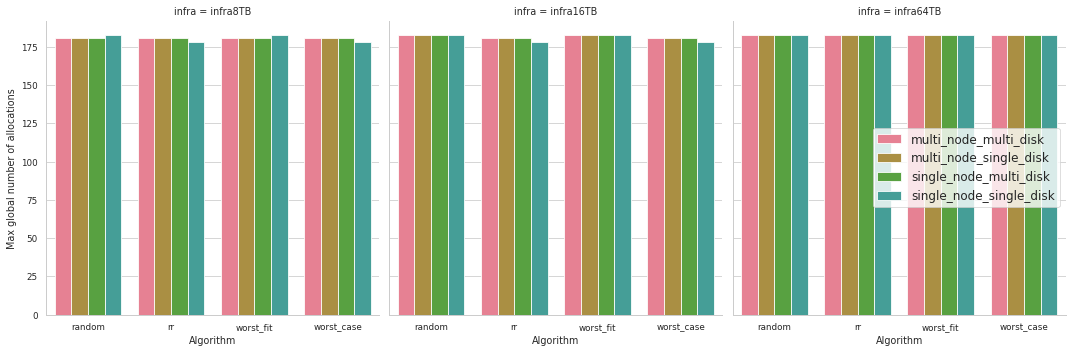

In [8]:
sns.set_theme(**categorical_theme_2)

# --- MAX CONCURRENT ALLOCATIONS (ALL NODES)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_concurrent_allocations", hue="system", col="infra", 
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Max global number of allocations", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

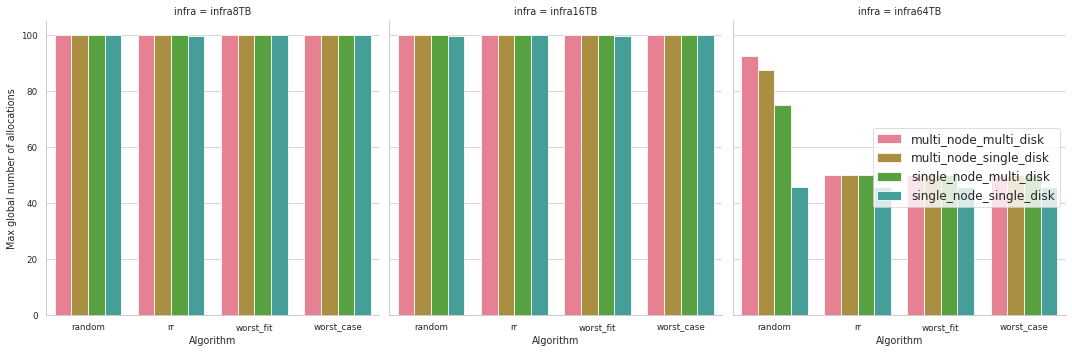

In [9]:
sns.set_theme(**categorical_theme_2)

# --- MAX NODE UTILISATION (ALL NODES)
# For platform with underfit capacity (8/16 TB), every algorithm reaches about 100% max node utilisation (see above how this is computed) : 
# it means at least 1 disk per node has reached 100% utilisation

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_node_utilisation", hue="system", col="infra", 
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Max global number of allocations", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

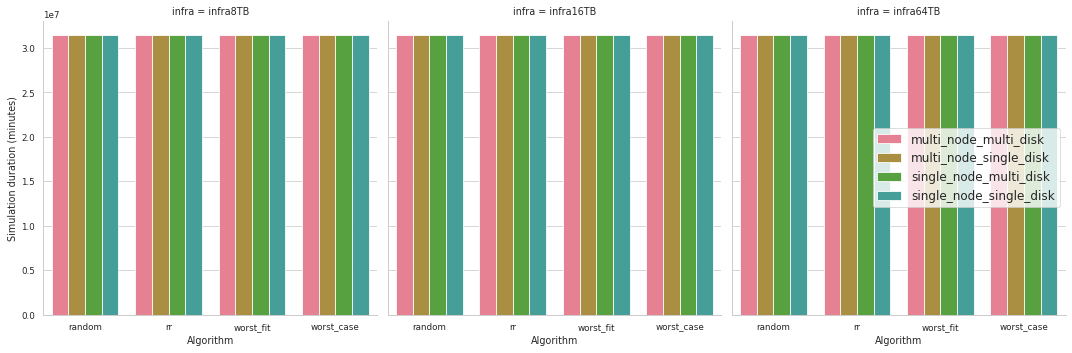

In [10]:
sns.set_theme(**categorical_theme_2)

# --- SIMULATION DURATION (ALL NODES)
# For every experiments, the entire dataset has been processed (no algorithm failed/crashed early)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="sim_duration", hue="system", col="infra", 
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Simulation duration (minutes)", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

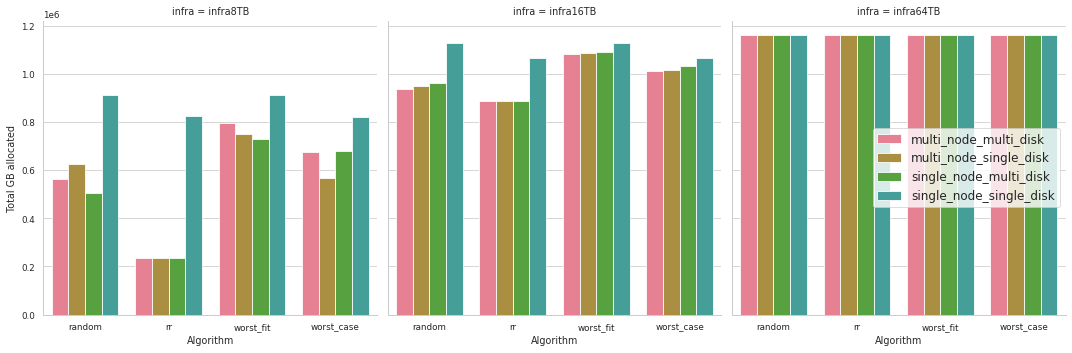

In [11]:
sns.set_theme(**categorical_theme_2)

# --- TOTAL GB ALLOCATED (ALL NODES)
# When there's not enough space, worst_fit and worst_case seem to be more resilient than rr and random.

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="tt_gb_allocated", hue="system", col="infra", 
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Total GB allocated", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

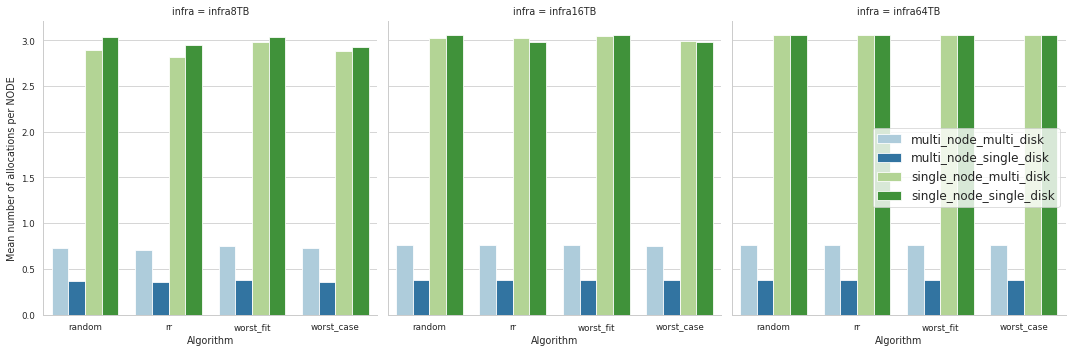

In [12]:
# [1] --- Mean number of allocations per node, for every algorithm => need to check hoaw this is computed...
# -> IF it's correct, it correspond to the mean number of allocation over the entire dataset period 
# Computed in the following way : if a disk has 1 allocation during 5s, and the dataset duration is 10s in total, then over the dataset duration period, this
# disk has (5s*1a + 5s*0a) / 10s) = 0.5. Our standard dataset is very sparse (there can be only a handful of allocations per day, lasting for as short 
# as a few minutes, and the dataset covers a whole year... so the means are quite low)

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="mean_node_alloc", hue="system", col="infra", 
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Mean number of allocations per NODE", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

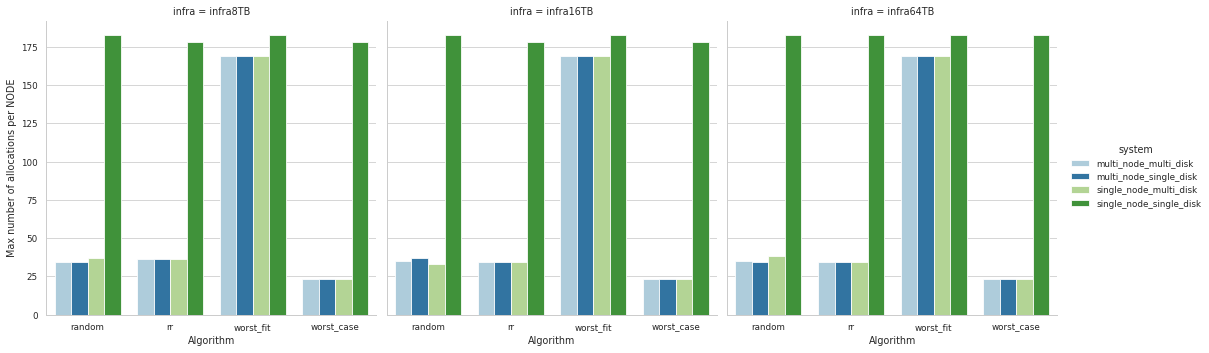

In [13]:
# [2] ---  Max number of allocations per node, for every algo (main parameters of the simulation are in its name)
# Corresponds to the max number of allocations for any single disk in the node. It can go very high because our dataset contains a period of 
# benchmarks around december 4th-7th, with huge number of very small and very short allocations each day.
# Worst_fit tends to have very high number of allocations for every kind of system, as it is its goal to always put allocations on the disk that already has
# the most.

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_node_alloc", hue="system", col="infra",
    col_order=infra_order, order=algo_order, sharey="row",
    height=5
)
g.set(ylabel="Max number of allocations per NODE", xlabel="Algorithm")

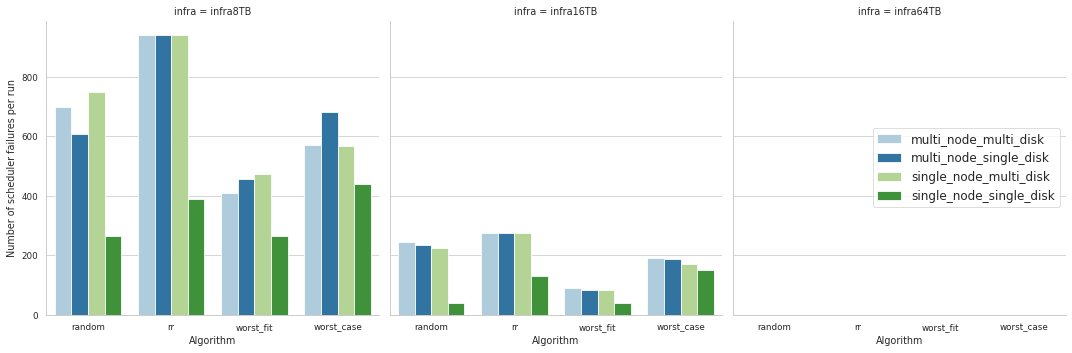

In [14]:
# [3] ---  Total number of scheduler failures, for every simulation
# Failures are of course dependent on the total capacity of the system. 
# Worst_case and round robin should be more resilient to failures but it's actually not really the case

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="nb_of_scheduler_failures", hue="system", col="infra", 
    col_order=infra_order, order=algo_order, sharey="row",
    height=5, legend=False
)
g.set(ylabel="Number of scheduler failures per run", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

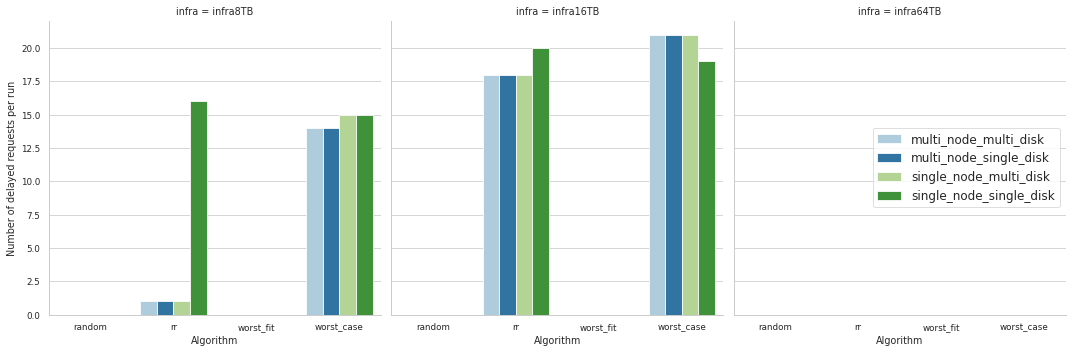

In [15]:
# [4] ---  Total number of delayed requests, for every simulation 
# (to be confirmed) only rr and worst_case are able to alert the scheduler that they didn't find a suitable choice, which allows for a retry with delayed 
# start_time. We see that worst_case is more prone to trigger retries with delays, but it also usually suffers from less failures than rr (as per previous graph)
# We might think that worst_case does a better job at knowing when a request won't be able to be allocated, and as per plot "TOTAL GB ALLOCATED (ALL NODES)",
# we can see more GB in total are allocated when using worst_case than when using rr

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="nb_of_delayed_requests", hue="system", col="infra",
    col_order=infra_order, order=algo_order, sharey="row",
    height=5, legend=False
)
g.set(ylabel="Number of delayed requests per run", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

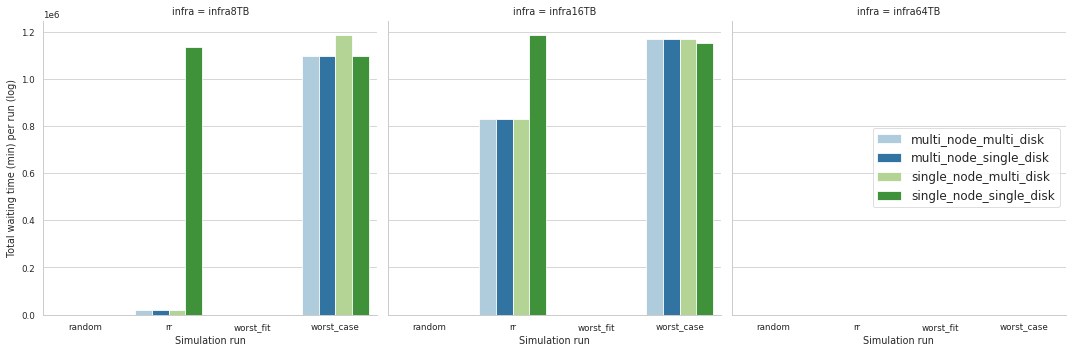

In [16]:
# [5] ---  Total cumulated waiting time for delayed requests, for every simulation
sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="tt_waiting_time_minutes", hue="system", col="infra",
    col_order=infra_order, order=algo_order, # sharey=False,
    height=5, legend=False
)
# g.set(yscale="log")
g.set(ylabel="Total waiting time (min) per run (log)", xlabel="Simulation run")
plt.legend(fontsize="12", loc="right")

In [17]:
# [6] ---  Create a second dataset where each row is a disk (instead of having one simulation per row)

data_by_disk = {
    "run_name": [],
    "node_id": [],
    "disk_id": [],
    "full_disk_id": [],
    "disk_mean_nb_alloc": [],
    "disk_max_nb_alloc": [],
    "disk_mean_cap_percent": [],
    "disk_max_cap_percent": [],
    "disk_capacity": [],
    "infra": [],
    "system": [],
    "algo": []
}

for idx, row in df_data.iterrows():
    for node in row['nodes']:
        for disk in node["disks"]:
            data_by_disk["run_name"].append(row['full_name'])
            data_by_disk["node_id"].append(node['id'])
            data_by_disk["disk_id"].append(disk['id'])
            data_by_disk["full_disk_id"].append(f"{node['id']}:{disk['id']}")
            data_by_disk["disk_mean_nb_alloc"].append(disk['mean_nb_alloc'])
            data_by_disk["disk_max_nb_alloc"].append(disk['max_alloc'])
            data_by_disk["disk_mean_cap_percent"].append(disk['mean_capacity_utilisation'])
            data_by_disk["disk_max_cap_percent"].append(disk['max_cap_utilisation'])
            data_by_disk["disk_capacity"].append(disk['capacity'])
            data_by_disk["infra"].append(row['infra'])
            data_by_disk["system"].append(row['system'])
            data_by_disk["algo"].append(row['algo'])
    
data_by_disk = pd.DataFrame(data_by_disk)
data_by_disk

,run_name,node_id,disk_id,full_disk_id,disk_mean_nb_alloc,disk_max_nb_alloc,disk_mean_cap_percent,disk_max_cap_percent,disk_capacity,infra,system,algo
0,random_infra16TB_multi_node_multi_disk_IOJobs,S-2eaded:0,0,S-2eaded:0:0,0.389,32,8.388,100.000,2000,infra16TB,multi_node_multi_disk,random
1,random_infra16TB_multi_node_multi_disk_IOJobs,S-2eaded:0,1,S-2eaded:0:1,0.361,32,5.070,100.000,2000,infra16TB,multi_node_multi_disk,random
2,random_infra16TB_multi_node_multi_disk_IOJobs,S-2eaded:1,0,S-2eaded:1:0,0.398,31,2.319,99.762,2000,infra16TB,multi_node_multi_disk,random
3,random_infra16TB_multi_node_multi_disk_IOJobs,S-2eaded:1,1,S-2eaded:1:1,0.372,32,3.146,100.000,2000,infra16TB,multi_node_multi_disk,random
4,random_infra16TB_multi_node_multi_disk_IOJobs,S-2eaded:2,0,S-2eaded:2:0,0.377,31,7.077,100.000,2000,infra16TB,multi_node_multi_disk,random
...,...,...,...,...,...,...,...,...,...,...,...,...
295,worst_case_infra64TB_single_node_single_disk_I...,S-120c7e:0,0,S-120c7e:0:0,3.065,183,0.601,45.588,64000,infra64TB,single_node_single_disk,worst_case
296,worst_fit_infra8TB_single_node_single_disk_IOJobs,S-63c7b1:0,0,S-63c7b1:0:0,3.042,183,5.123,100.000,8000,infra8TB,single_node_single_disk,worst_fit
297,random_infra16TB_single_node_single_disk_IOJobs,S-914c03:0,0,S-914c03:0:0,3.059,183,2.734,99.610,16000,infra16TB,single_node_single_disk,random
298,rr_infra16TB_single_node_single_disk_IOJobs,S-957d4a:0,0,S-957d4a:0:0,2.987,178,2.577,99.719,16000,infra16TB,single_node_single_disk,rr


In [18]:
data_by_disk = data_by_disk.sort_values(["algo",], ascending=True)

In [19]:
categorical_theme_disk = {
    "context": "paper",            
    "palette": "colorblind", 
    "style": "whitegrid", 
}

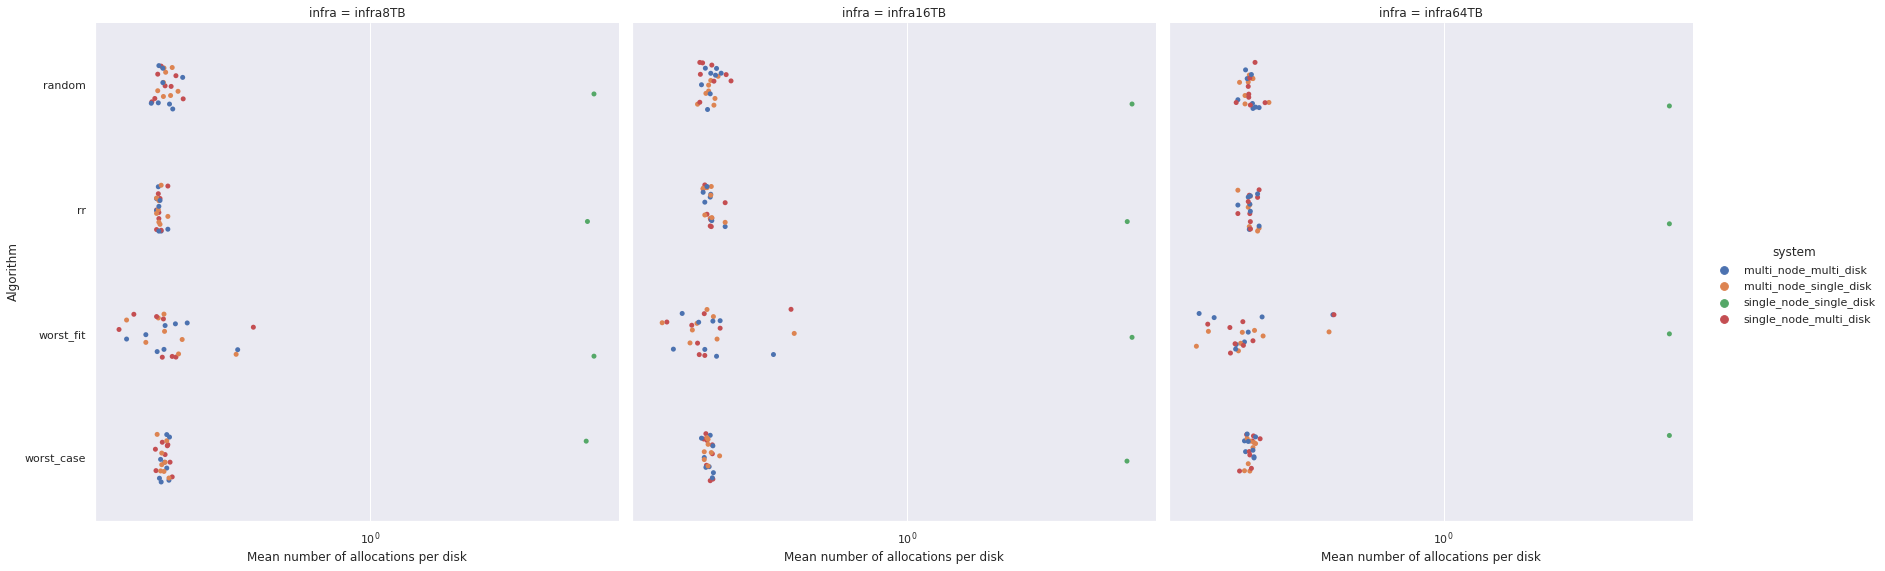

In [20]:
# [7] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip",
    y="algo", x="disk_mean_nb_alloc",hue="system", col="infra",
    height=8, jitter=0.2, col_order=infra_order, order=algo_order
)
g.set(xscale="log")
g.set_axis_labels("Mean number of allocations per disk", "Algorithm")

[Text(0, 0.5, 'Simulation run'),
 Text(0.5, 0, 'Mean number of allocations per node')]

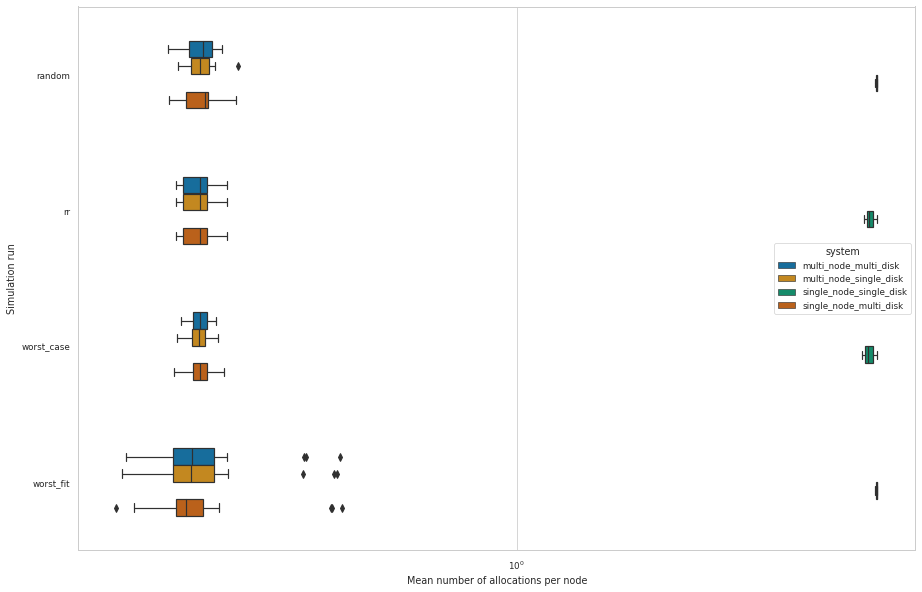

In [21]:
# [8] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

# sns.set(rc={'figure.figsize':(29.7,21)})
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="algo", x="disk_mean_nb_alloc", hue="system", 
    dodge=True, width=0.5,
)
g.set(xscale="log")
g.set(ylabel="Simulation run", xlabel="Mean number of allocations per node")

[Text(0, 0.5, 'Mean nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

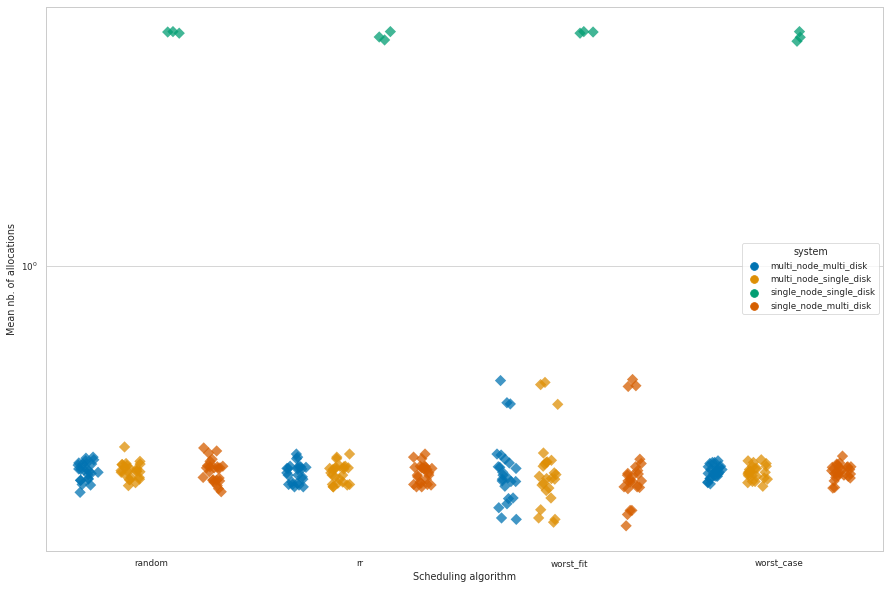

In [22]:
# [9] ---  Mean number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2, order=algo_order
)
g.set(yscale="log")
g.set(ylabel="Mean nb. of allocations", xlabel="Scheduling algorithm")

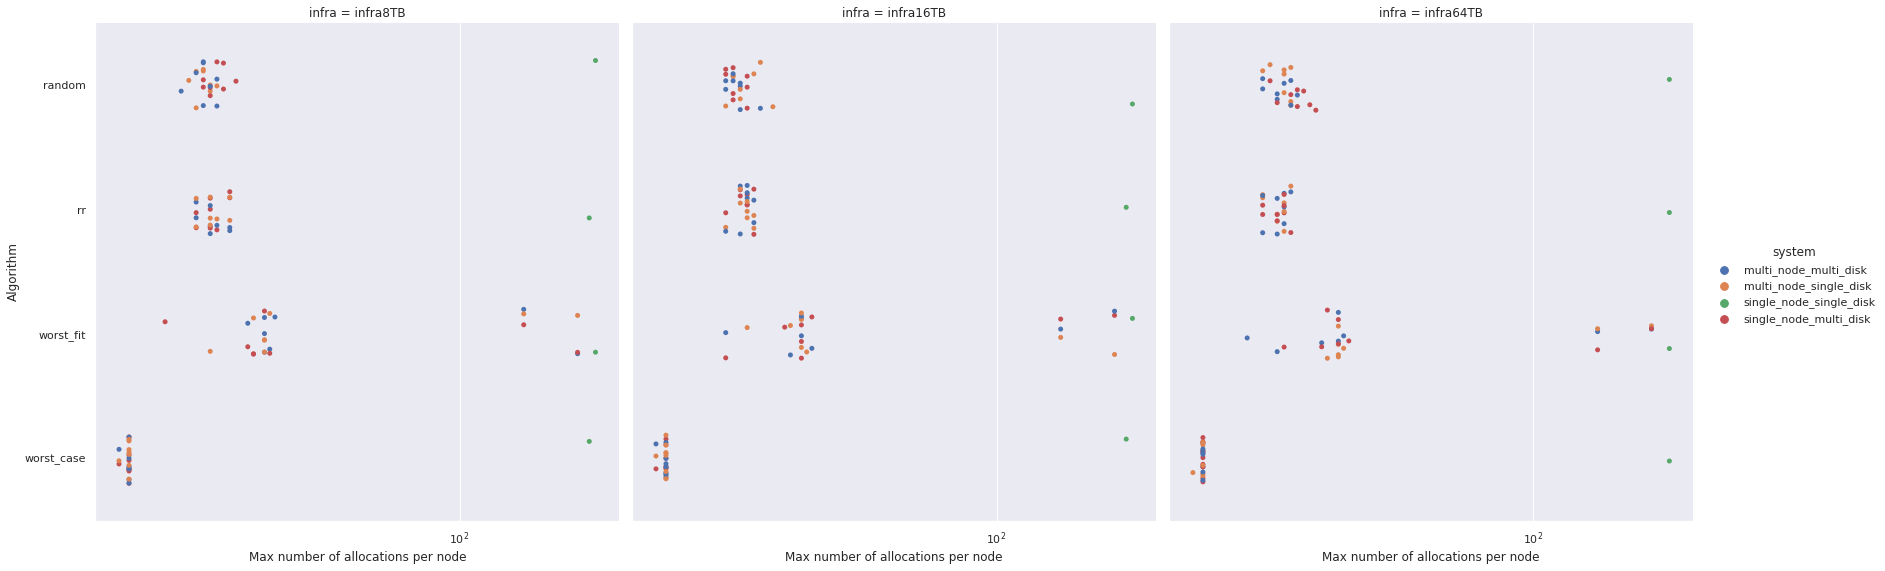

In [23]:
# [10] ---  Max number of allocations per disk, organised by simulation run and infrastructure (1/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip", col="infra",
    y="algo", x="disk_max_nb_alloc",hue="system",
    height=8, jitter=0.2,
    col_order=infra_order, order=algo_order
)
g.set(xscale="log")
g.set_axis_labels("Max number of allocations per node", "Algorithm")

[Text(0, 0.5, 'Algorithm'), Text(0.5, 0, 'Max number of allocations per node')]

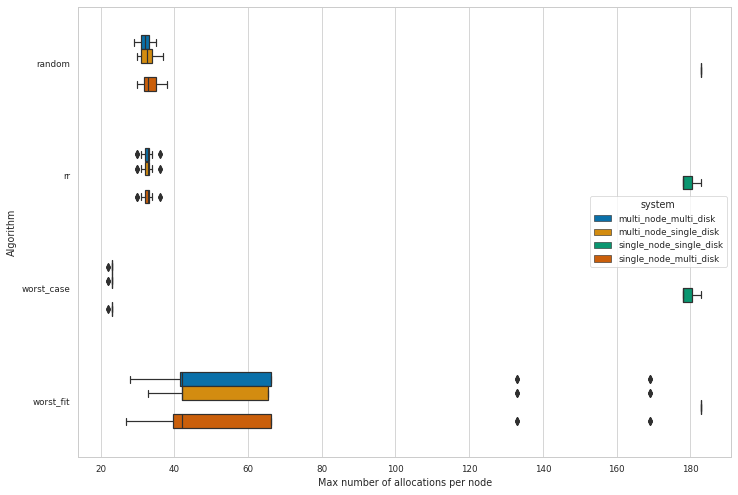

In [24]:
# [11] ---  Max number of allocations per disk, organised by simulation run and infrastructure (2/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="algo", x="disk_max_nb_alloc", hue="system",
    dodge=True, width=0.5, saturation=0.9
)
g.set(ylabel="Algorithm", xlabel="Max number of allocations per node")

[Text(0, 0.5, 'Max nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

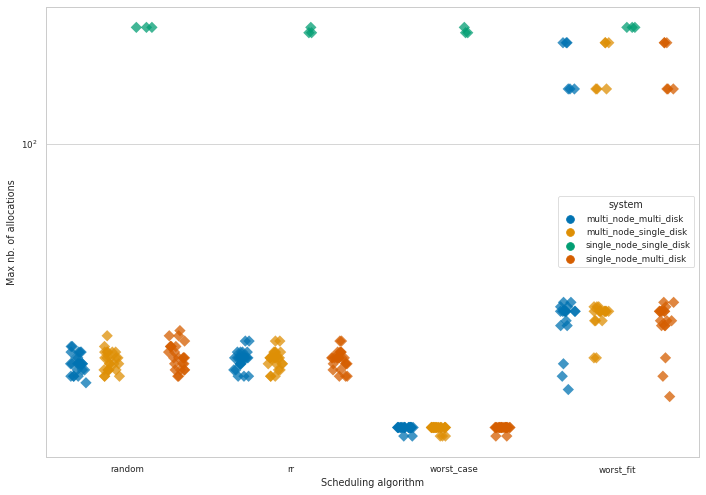

In [25]:
# [12] ---  Max number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(yscale="log")
g.set(ylabel="Max nb. of allocations", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Mean capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

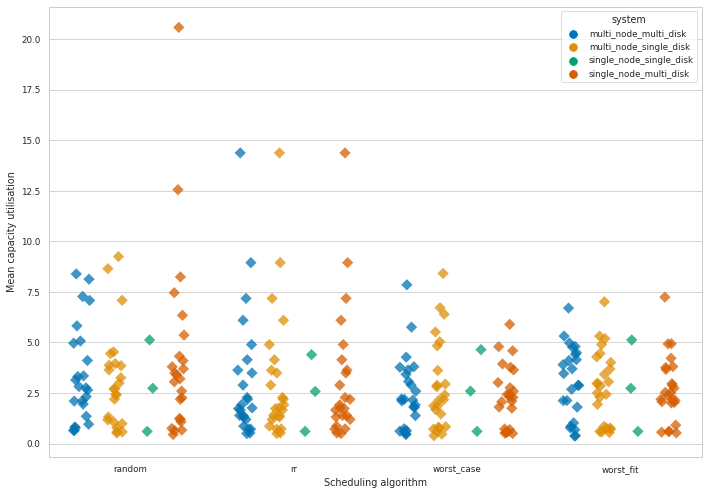

In [26]:
# [13] ---  Mean capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Mean capacity utilisation", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Max capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

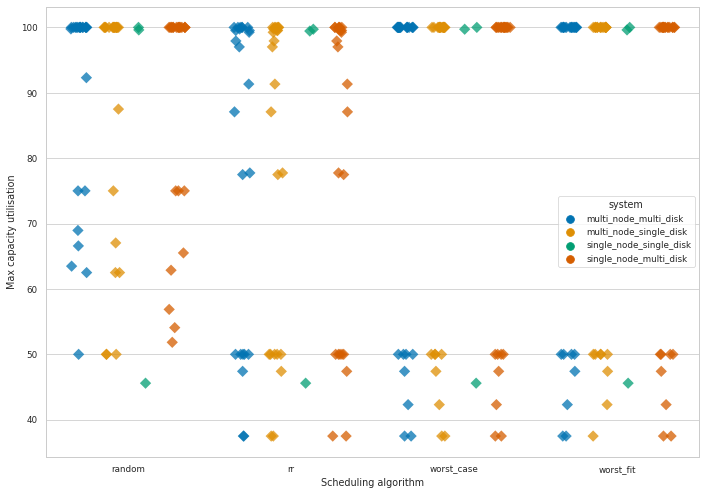

In [27]:
# [14] --- Max capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Max capacity utilisation", xlabel="Scheduling algorithm")

In [28]:
data_by_disk_mean_alloc = data_by_disk.sort_values(["disk_mean_nb_alloc",], ascending=True)

[None]

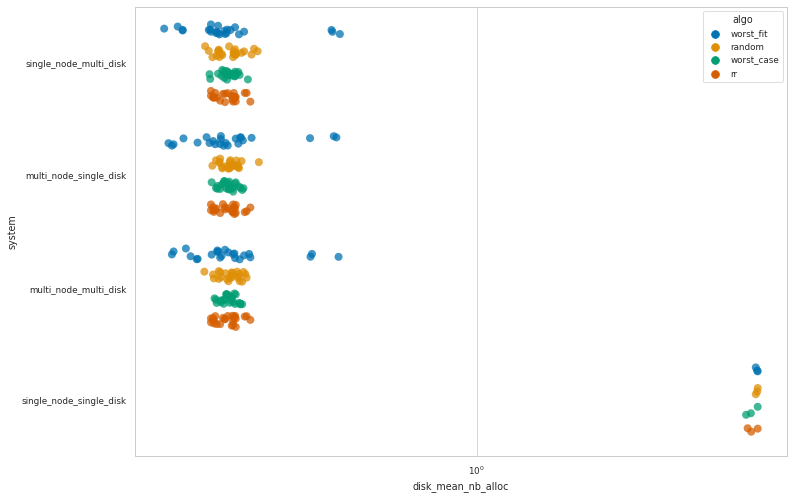

In [29]:
# [15] --- Disk mean nb alloc per run, with hue on Node ID 

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk_mean_alloc,
    y="system", x="disk_mean_nb_alloc",size=8, jitter=0.2, alpha=0.75,
    dodge=True,
    hue="algo",
)
g.set(xscale="log")


# g.xaxis.grid(True, "minor", linewidth=.25)
#g = sns.catplot(x="disk_mean_nb_alloc", y="run_name",
#                hue="node_id",
#                data=data_by_disk_sorted, kind="swarm",
#                alpha=.6, height=21, aspect=29.7/21);

#g.set(xscale="log")
# g.xaxis.grid(True, "minor", linewidth=.25)

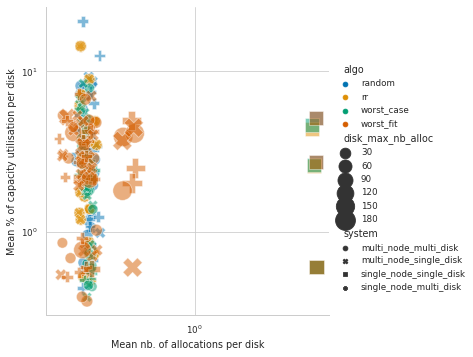

In [30]:
# [16] --- Disk mean nb of alloc compared to disk mean capacity utilisation

sns.set(rc={'figure.figsize':(29.7,21)})
sns.set_theme(**categorical_theme_disk)

#sns.set_style("whitegrid")
g = sns.relplot(
    x="disk_mean_nb_alloc", 
    y="disk_mean_cap_percent", 
    hue="algo", 
    style="system",
    size="disk_max_nb_alloc",
    sizes=(100, 400), 
    alpha=.50,
    height=5, 
    data=data_by_disk
)
g.set(
    xscale="log", 
    yscale="log", 
    xlabel="Mean nb. of allocations per disk", 
    ylabel="Mean % of capacity utilisation per disk"
)

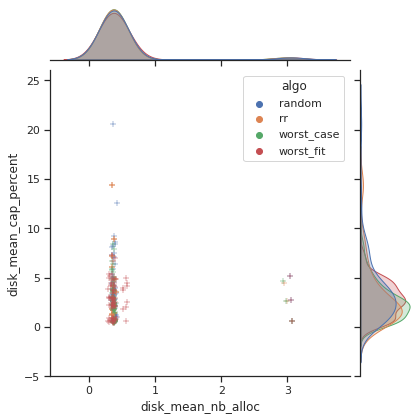

In [31]:
# [16] ---

sns.set_theme(style="ticks")

cmap = sns.hls_palette(n_colors=data_by_disk['algo'].nunique())

g = sns.jointplot(data=data_by_disk, x="disk_mean_nb_alloc", 
                  y="disk_mean_cap_percent", 
                  hue="algo", marker="+")
#g.set(
#    xscale="log", 
#    yscale="log", 
#    xlabel="Mean nb. of allocations per disk", 
#    ylabel="Mean % of capacity utilisation per disk"
#)